In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [2]:
field_types_file = r'../utilfiles/codes_after_reduction.csv'
numerical_N_date_sample_dataset_without_nulls = r'numerical_N_date_sample_dataset_without_nulls.csv'

In [3]:
sample_df = pd.read_csv("sample_dataset.csv")

/tmp/ipykernel_33850/1162764849.py:1: DtypeWarning: Columns (470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_df = pd.read_csv("sample_dataset.csv")


In [4]:
field_types_df = pd.read_csv(field_types_file)

# Create a dictionary with field names as keys and field types as values
field_types = dict(zip(field_types_df['codes'], field_types_df['dataType']))

numerical_fields = [field for field, dtype in field_types.items() if dtype == 'Integer']
continuous_fields = [field for field, dtype in field_types.items() if dtype == 'Continuous']

In [5]:
only_numericals_sample_df = sample_df[numerical_fields + continuous_fields + ['target']]

In [6]:
date_N_numericals_sample_df_without_nulls = only_numericals_sample_df.fillna(only_numericals_sample_df.median())

In [8]:
date_N_numericals_sample_df_without_nulls.to_csv(numerical_N_date_sample_dataset_without_nulls)

In [7]:
def find_original_code(target_string,prefixes):
    for prefix in prefixes:
        if target_string.startswith(prefix):
            return prefix

In [8]:
all_numeric_fields = numerical_fields + continuous_fields

In [9]:
feature_names_df = pd.read_csv(r'../utilfiles/codes_after_reduction.csv')

feature_name_map = pd.Series(feature_names_df.description.values, index=feature_names_df.codes).to_dict()

def convert_feature_code_to_name(feature_code):
    code_founded = find_original_code(feature_code,all_numeric_fields)
    if feature_name_map.get(code_founded, code_founded) == None:
        print(feature_code)
    return feature_name_map.get(code_founded, code_founded) + ' - ' + code_founded

***pearson's correlation test***

In [21]:
corr_matrix = date_N_numericals_sample_df_without_nulls.corr()
converted_columns = [convert_feature_code_to_name(col) for col in corr_matrix.columns if col != 'target'] + ['target']
corr_matrix.columns = converted_columns
corr_matrix.index = converted_columns

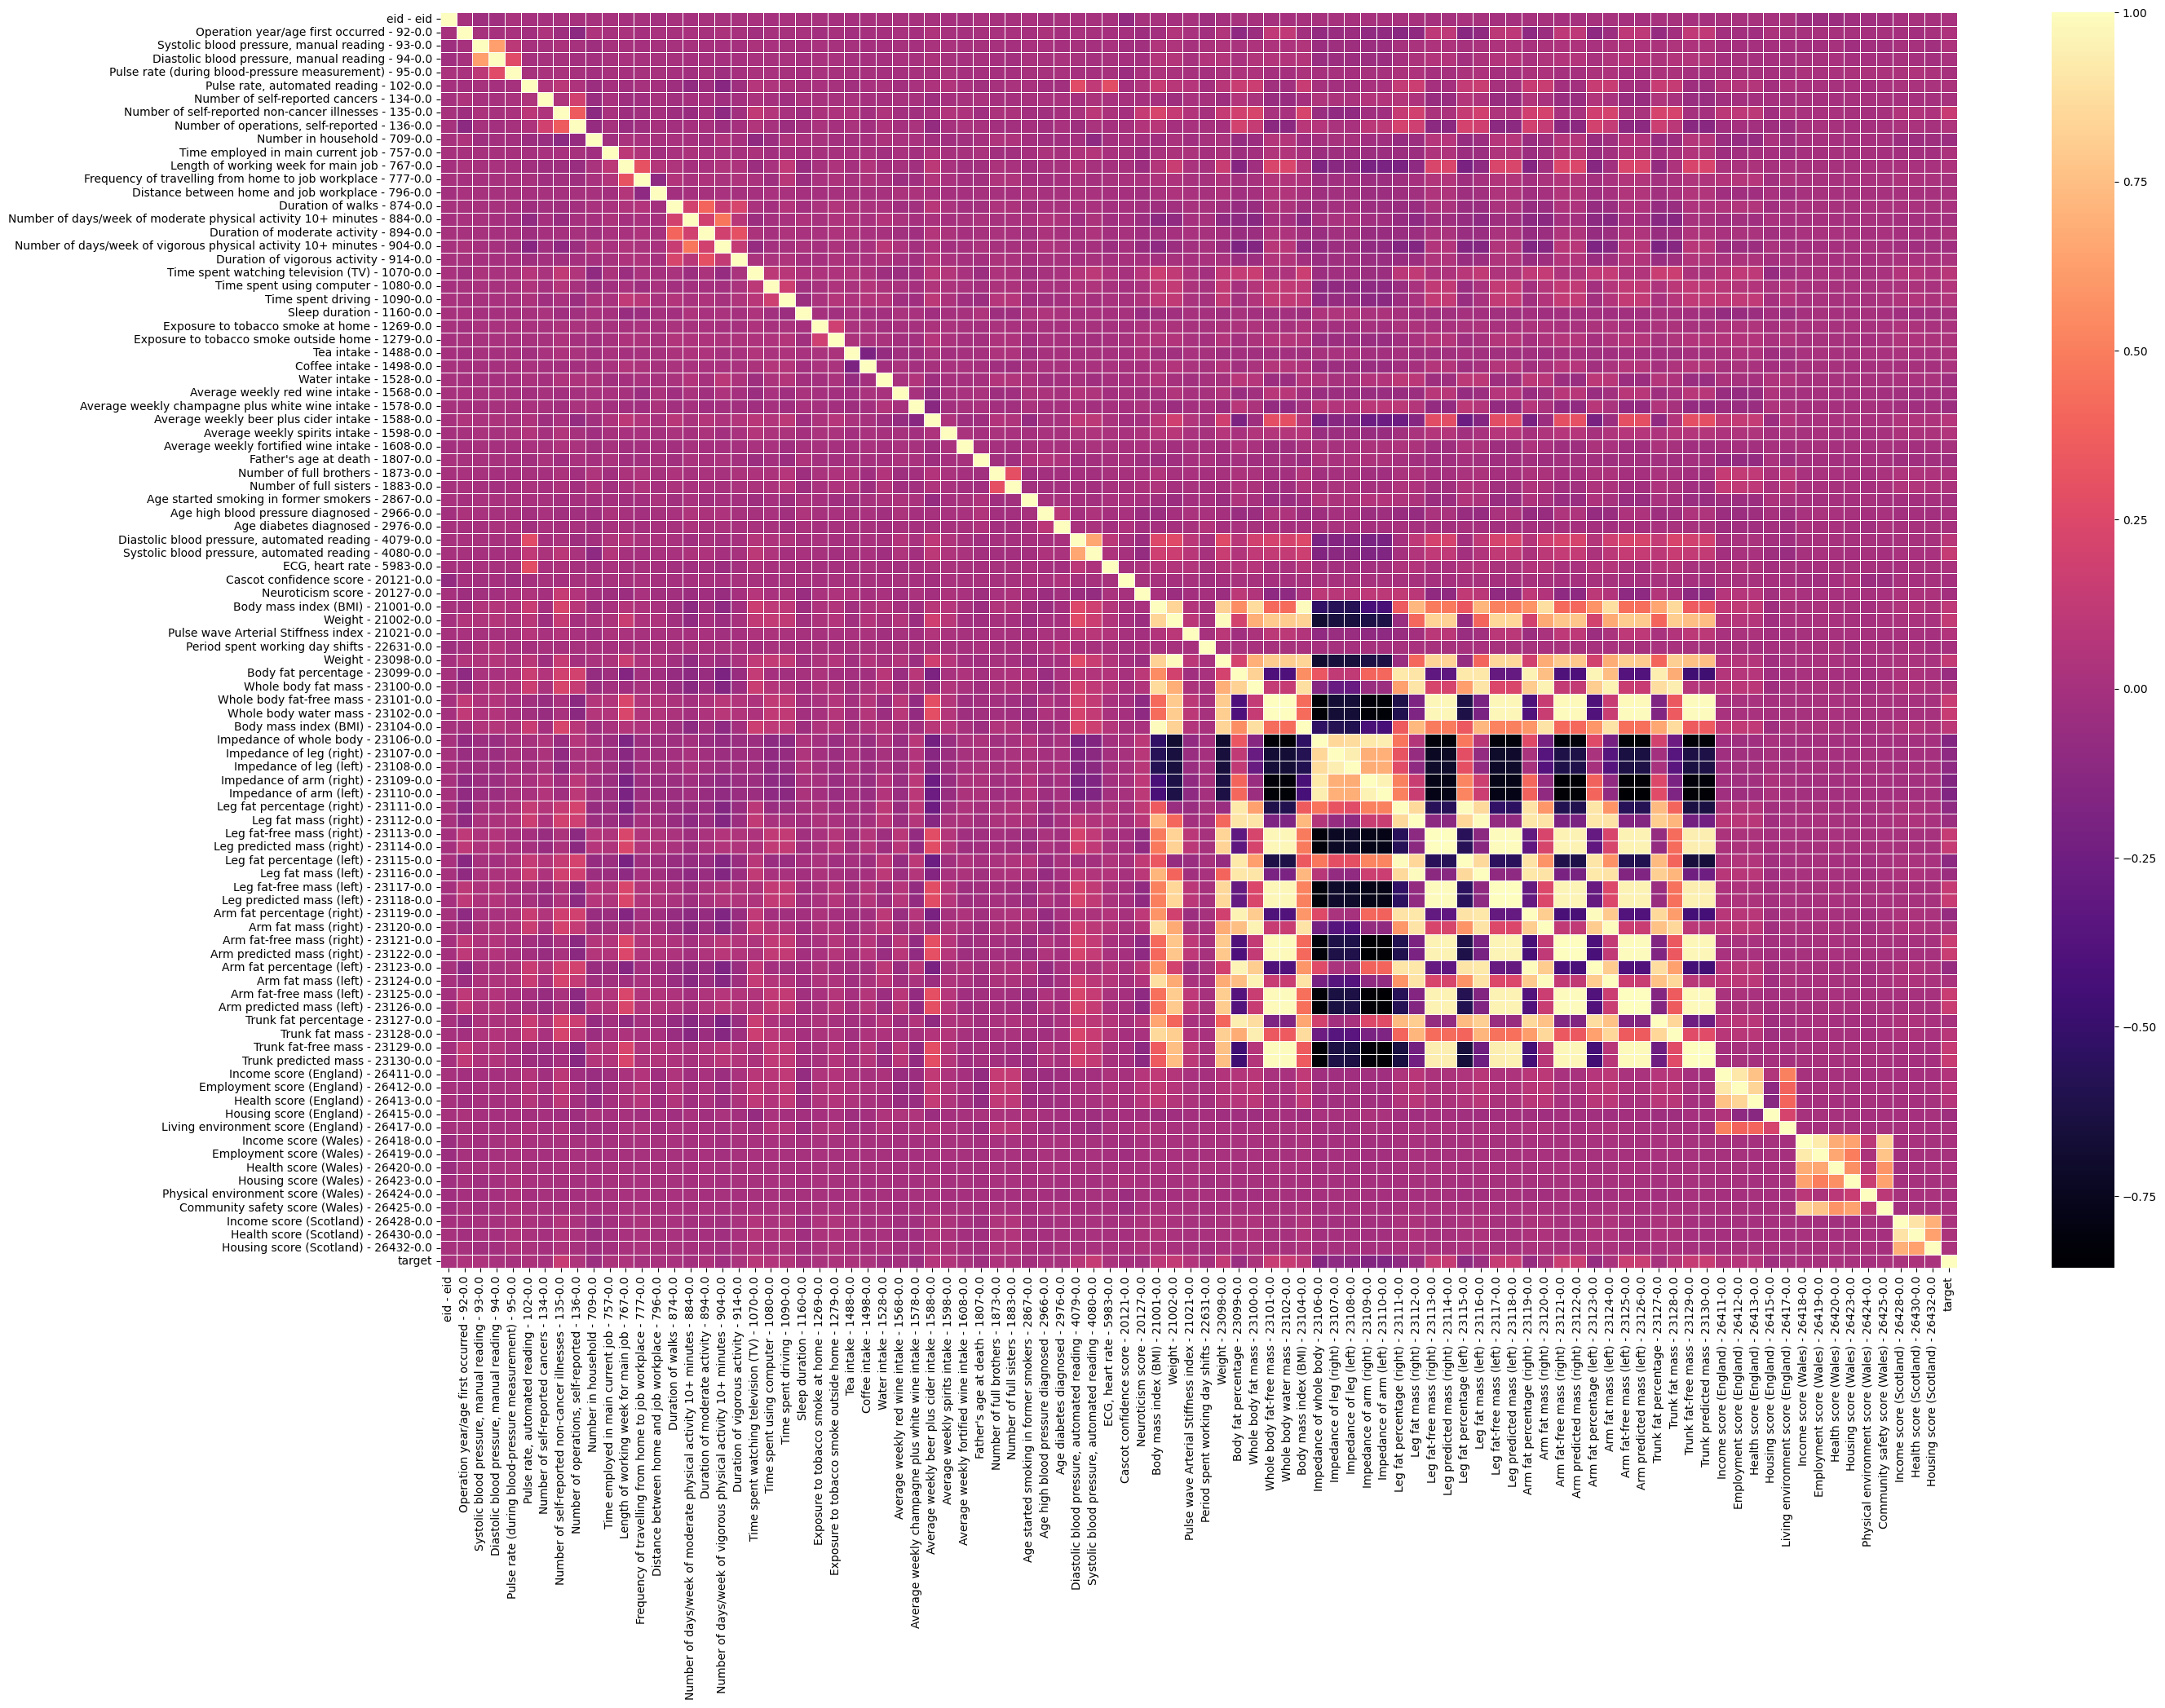

In [22]:
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=False, cmap="magma", linewidths=0.5)
plt.savefig("pearson's_corr_on_numeric_var_graph.png", format='png')
plt.show()

In [23]:
corr_matrix.to_csv('correlation_matrix_numeric_on_sample.csv')

***Anova f-test***

In [11]:
X = date_N_numericals_sample_df_without_nulls.drop(columns=['target', 'eid'])
y = date_N_numericals_sample_df_without_nulls['target']

In [24]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_standardized, y)
f_scores = selector.scores_
f_scores_series = pd.Series(f_scores, index=X.columns)
f_scores_series.index = [convert_feature_code_to_name(col) for col in f_scores_series.index]
f_scores_series = f_scores_series.sort_values(ascending=False)

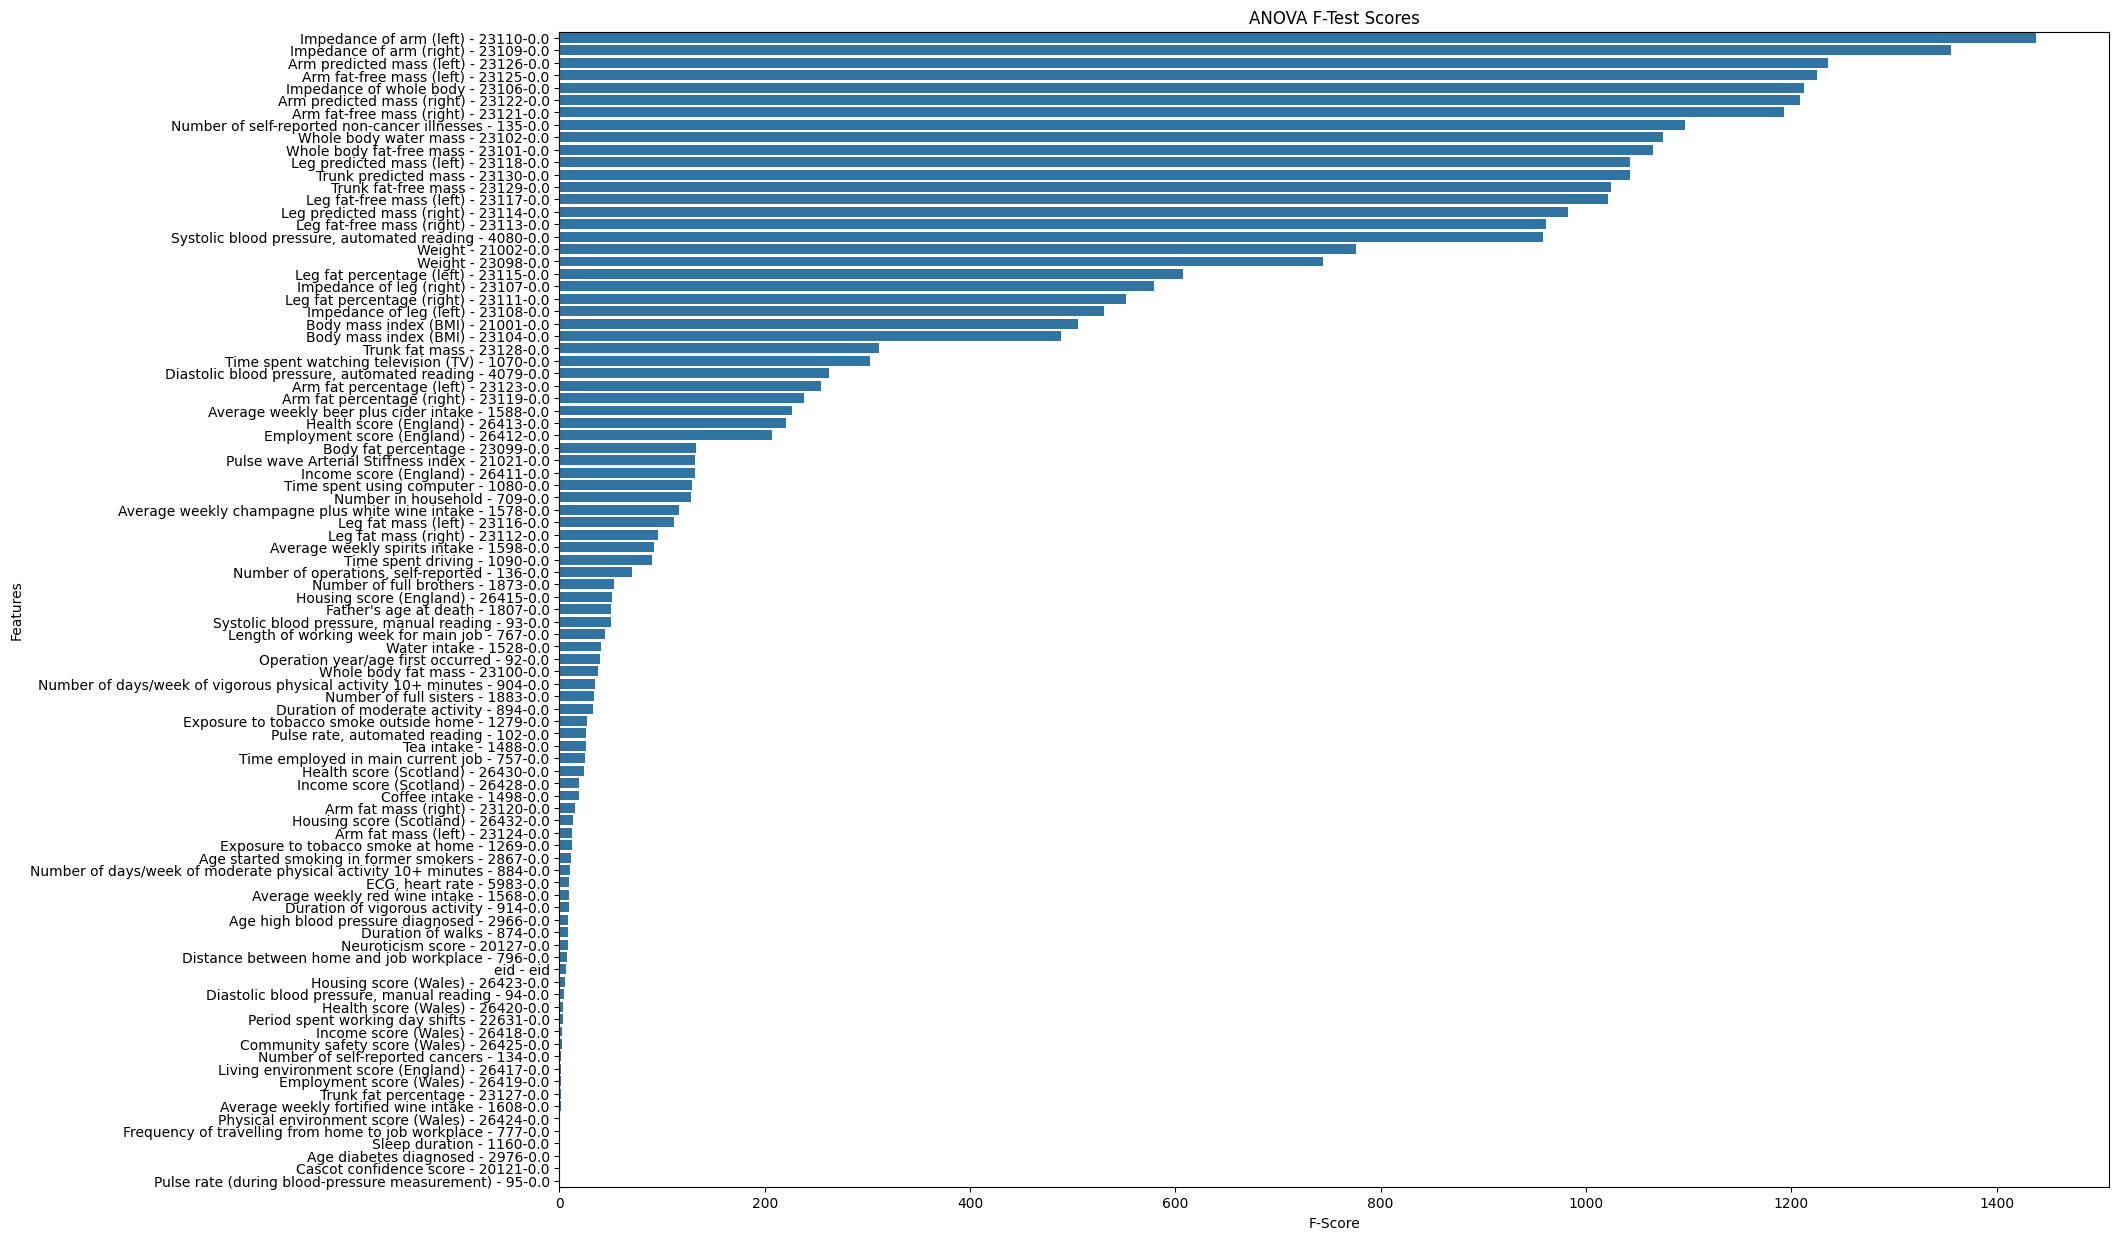

In [25]:
plt.figure(figsize=(20, 15))
sns.barplot(x=f_scores_series.values, y=f_scores_series.index)
plt.title('ANOVA F-Test Scores')
plt.xlabel('F-Score')
plt.ylabel('Features')

plt.savefig('anova_f_test_scores_on_numeric_var_graph.png', bbox_inches='tight')
plt.show()

***Random Forest***

In [26]:
model = RandomForestClassifier()
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.index = [convert_feature_code_to_name(col) for col in importances.index]
importances = importances.sort_values(ascending=False)

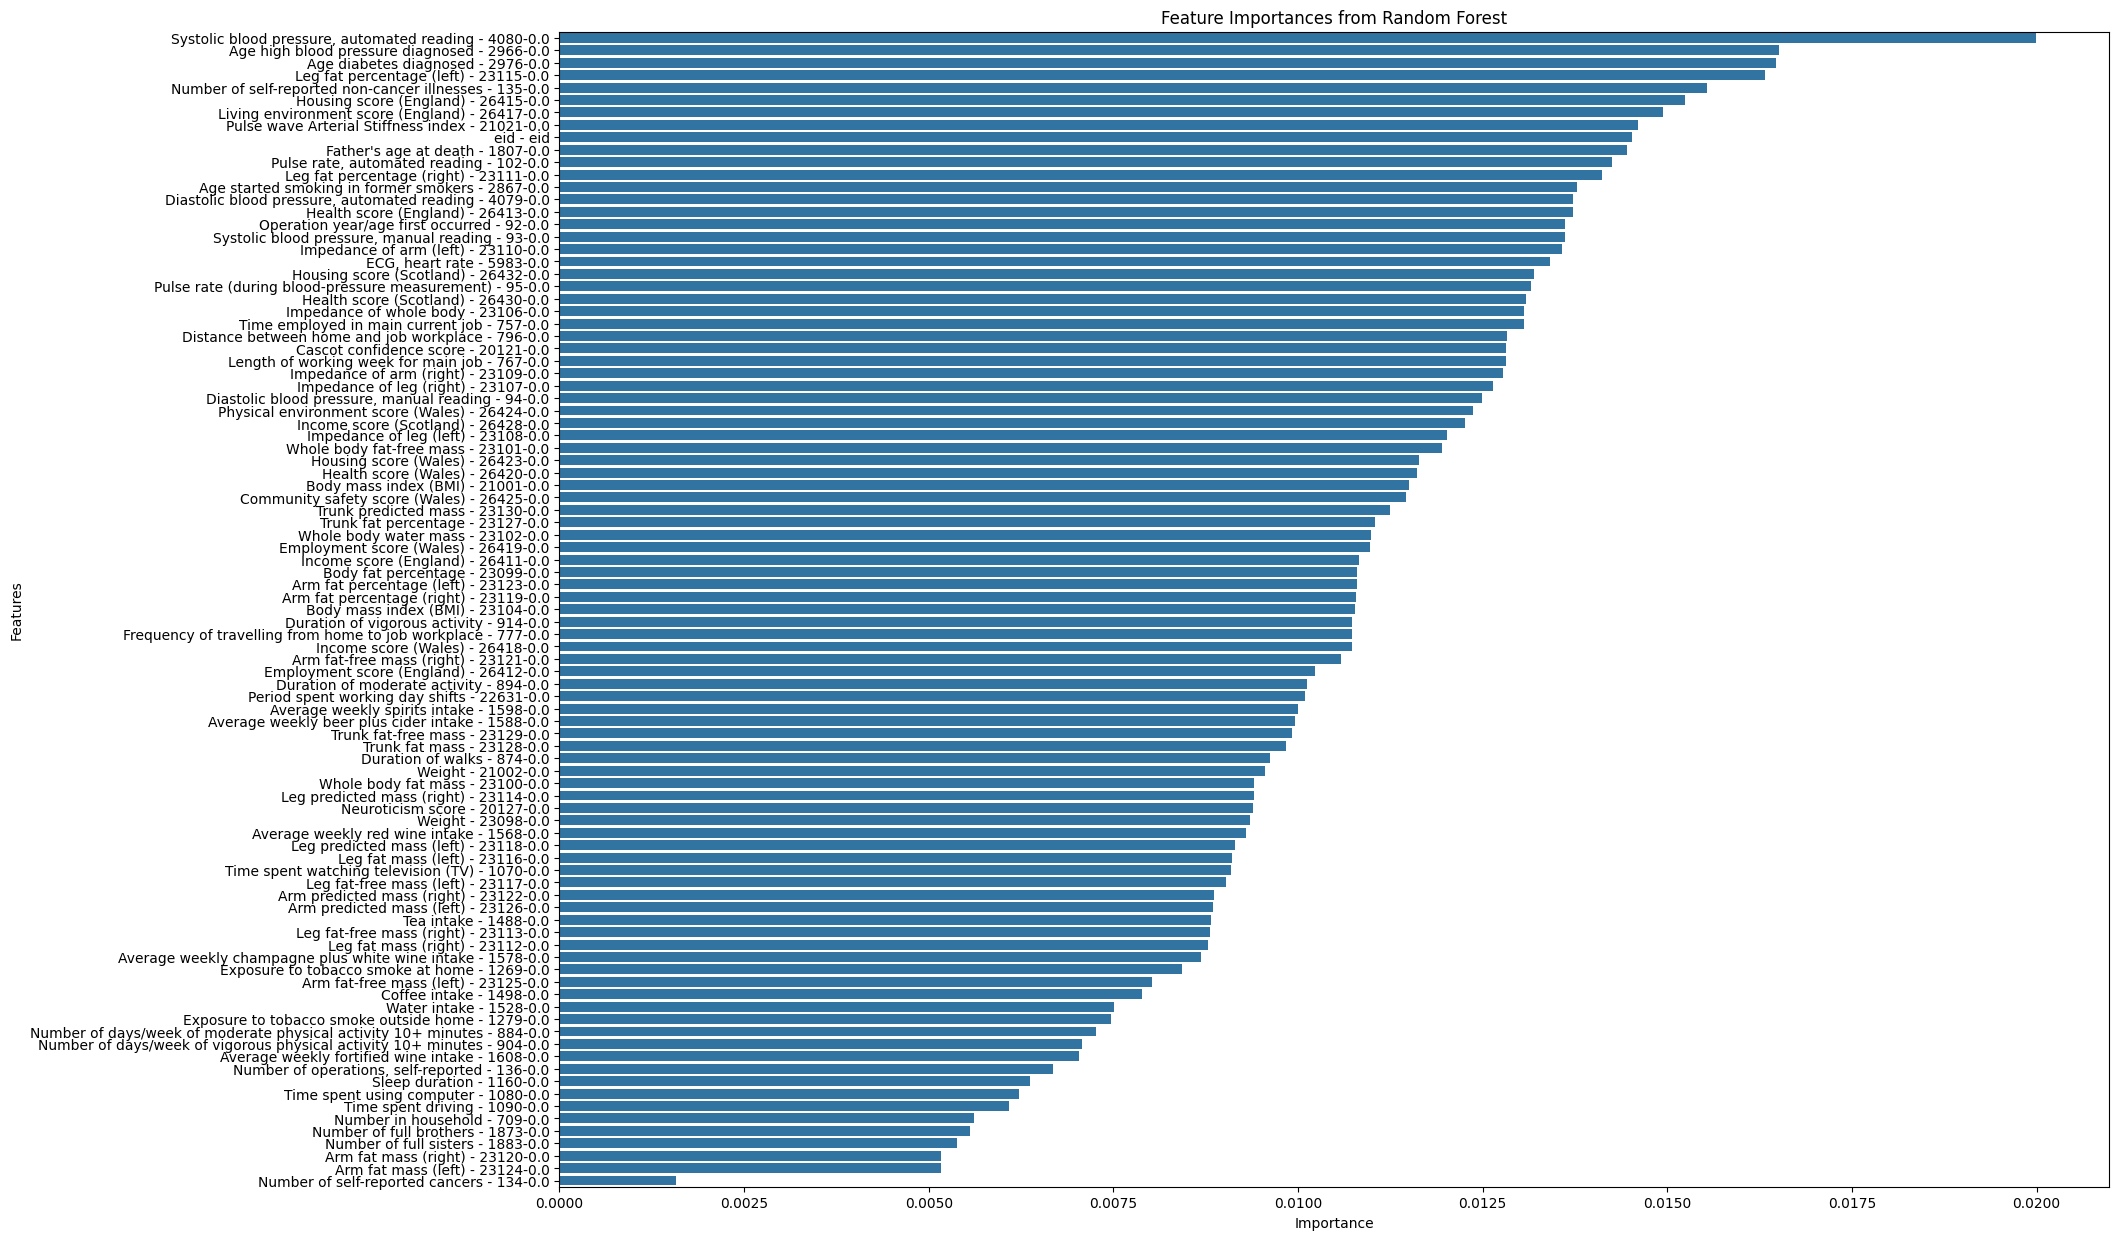

In [27]:
plt.figure(figsize=(20, 15))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')

# Save the plot as PNG
plt.savefig('random_forest_feature_importance.png', bbox_inches='tight')
plt.show()

***Mutual information***

In [11]:
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns)
mi_series.index = [convert_feature_code_to_name(col) for col in mi_series.index]
mi_series = mi_series.sort_values(ascending=False)

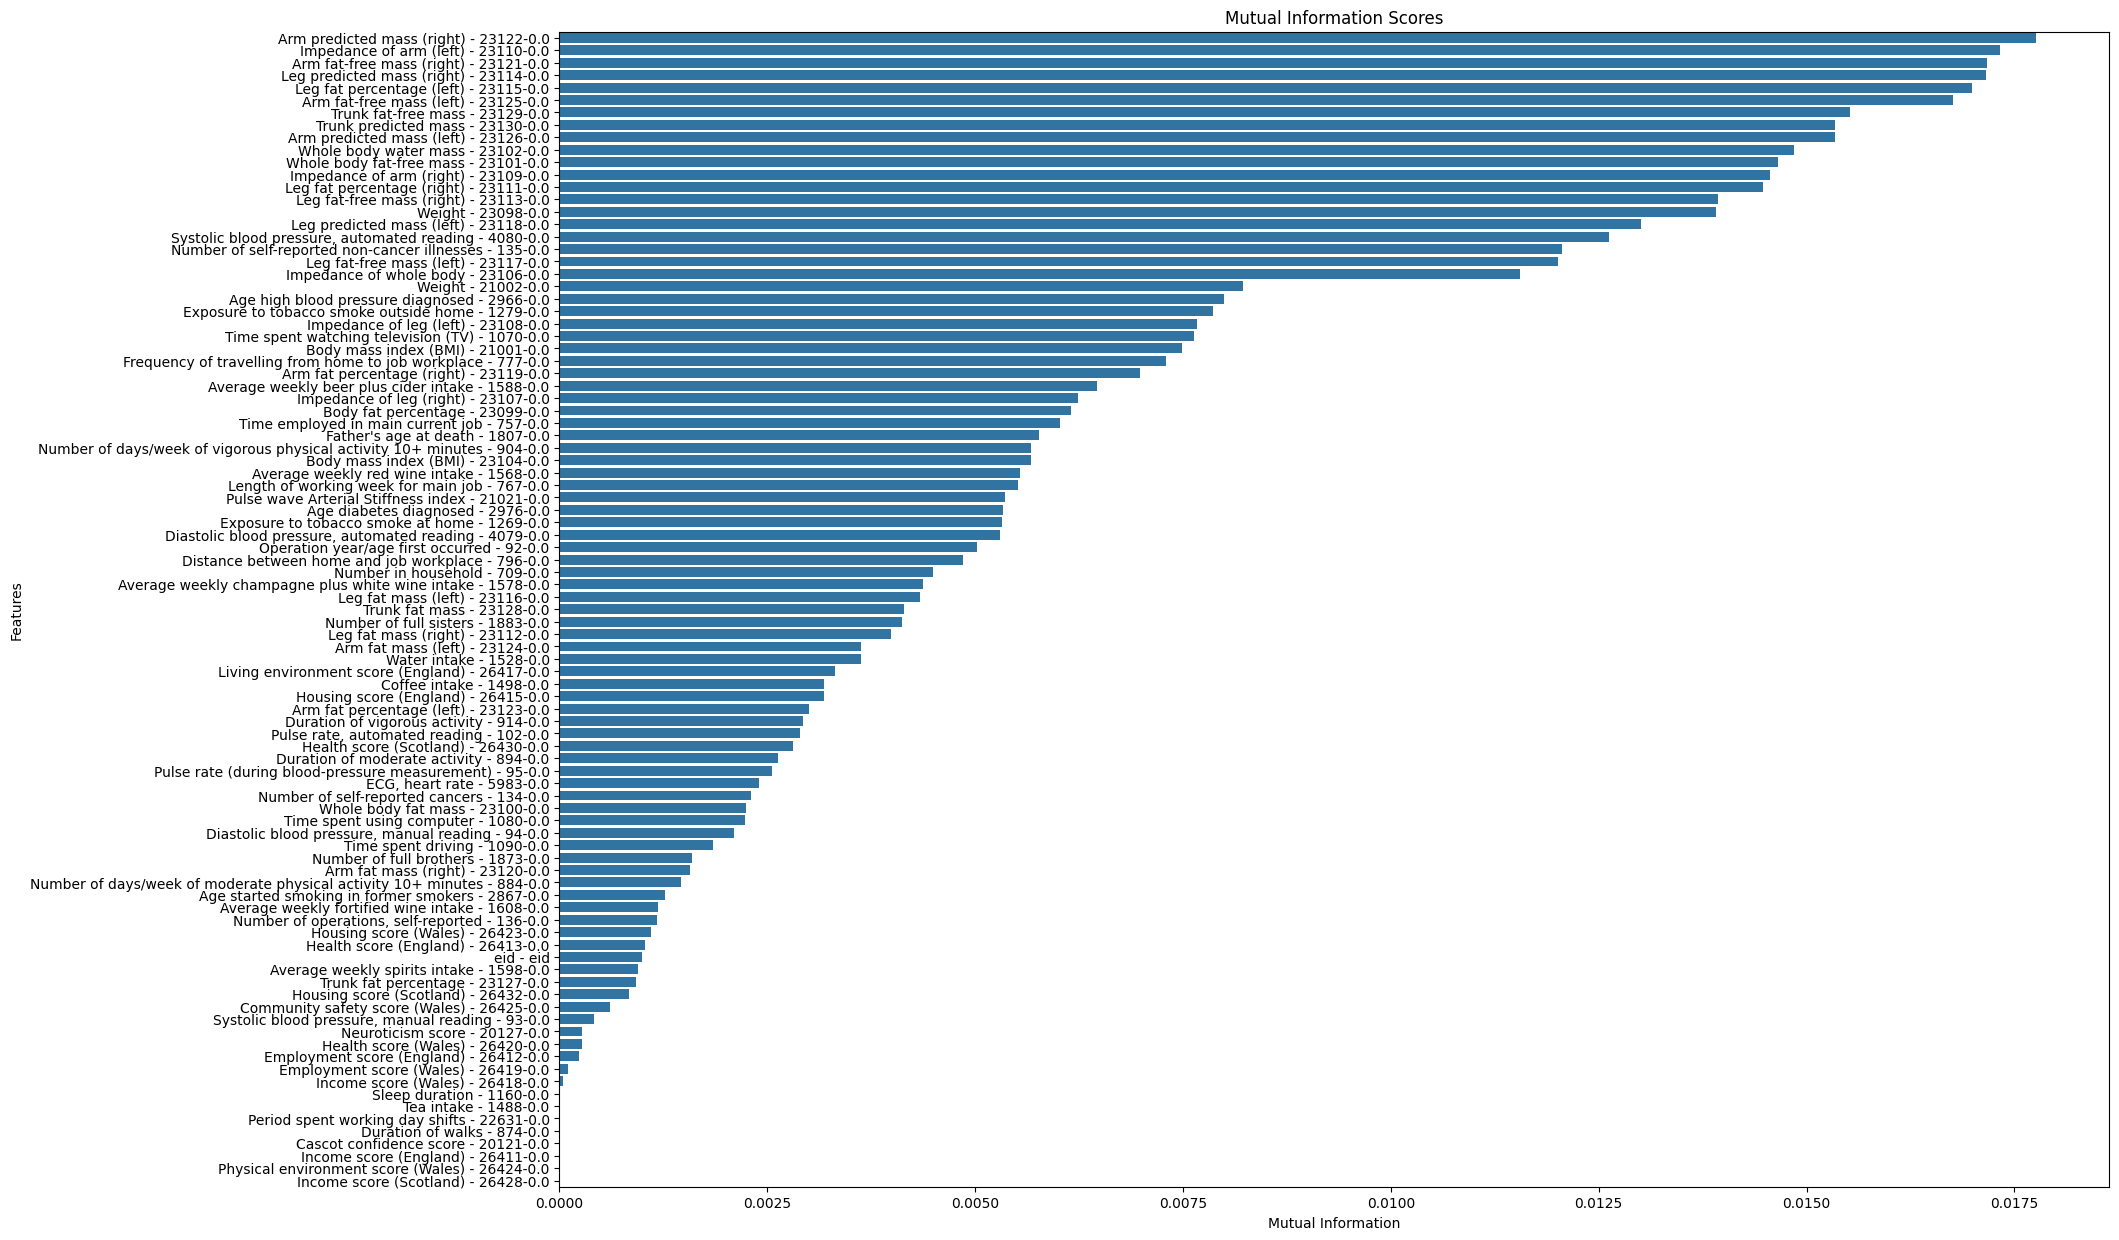

In [12]:
plt.figure(figsize=(20, 15))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title('Mutual Information Scores')
plt.xlabel('Mutual Information')
plt.ylabel('Features')

plt.savefig('mutual_information_scores.png', bbox_inches='tight')
plt.show()

***LightGBM***

In [12]:
train_data = lgb.Dataset(X, label = y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate" : 0.1,
    "bagging_fraction" : 0.8,
    "feature_fraction" : 0.8
}

In [15]:
model = lgb.train(params, train_data, num_boost_round=500)
importance = model.feature_importance(importance_type="gain")
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})
importance_df['Feature'] = importance_df['Feature'].apply(convert_feature_code_to_name)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

[LightGBM] [Info] Number of positive: 9665, number of negative: 38660
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19467
[LightGBM] [Info] Number of data points in the train set: 48325, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


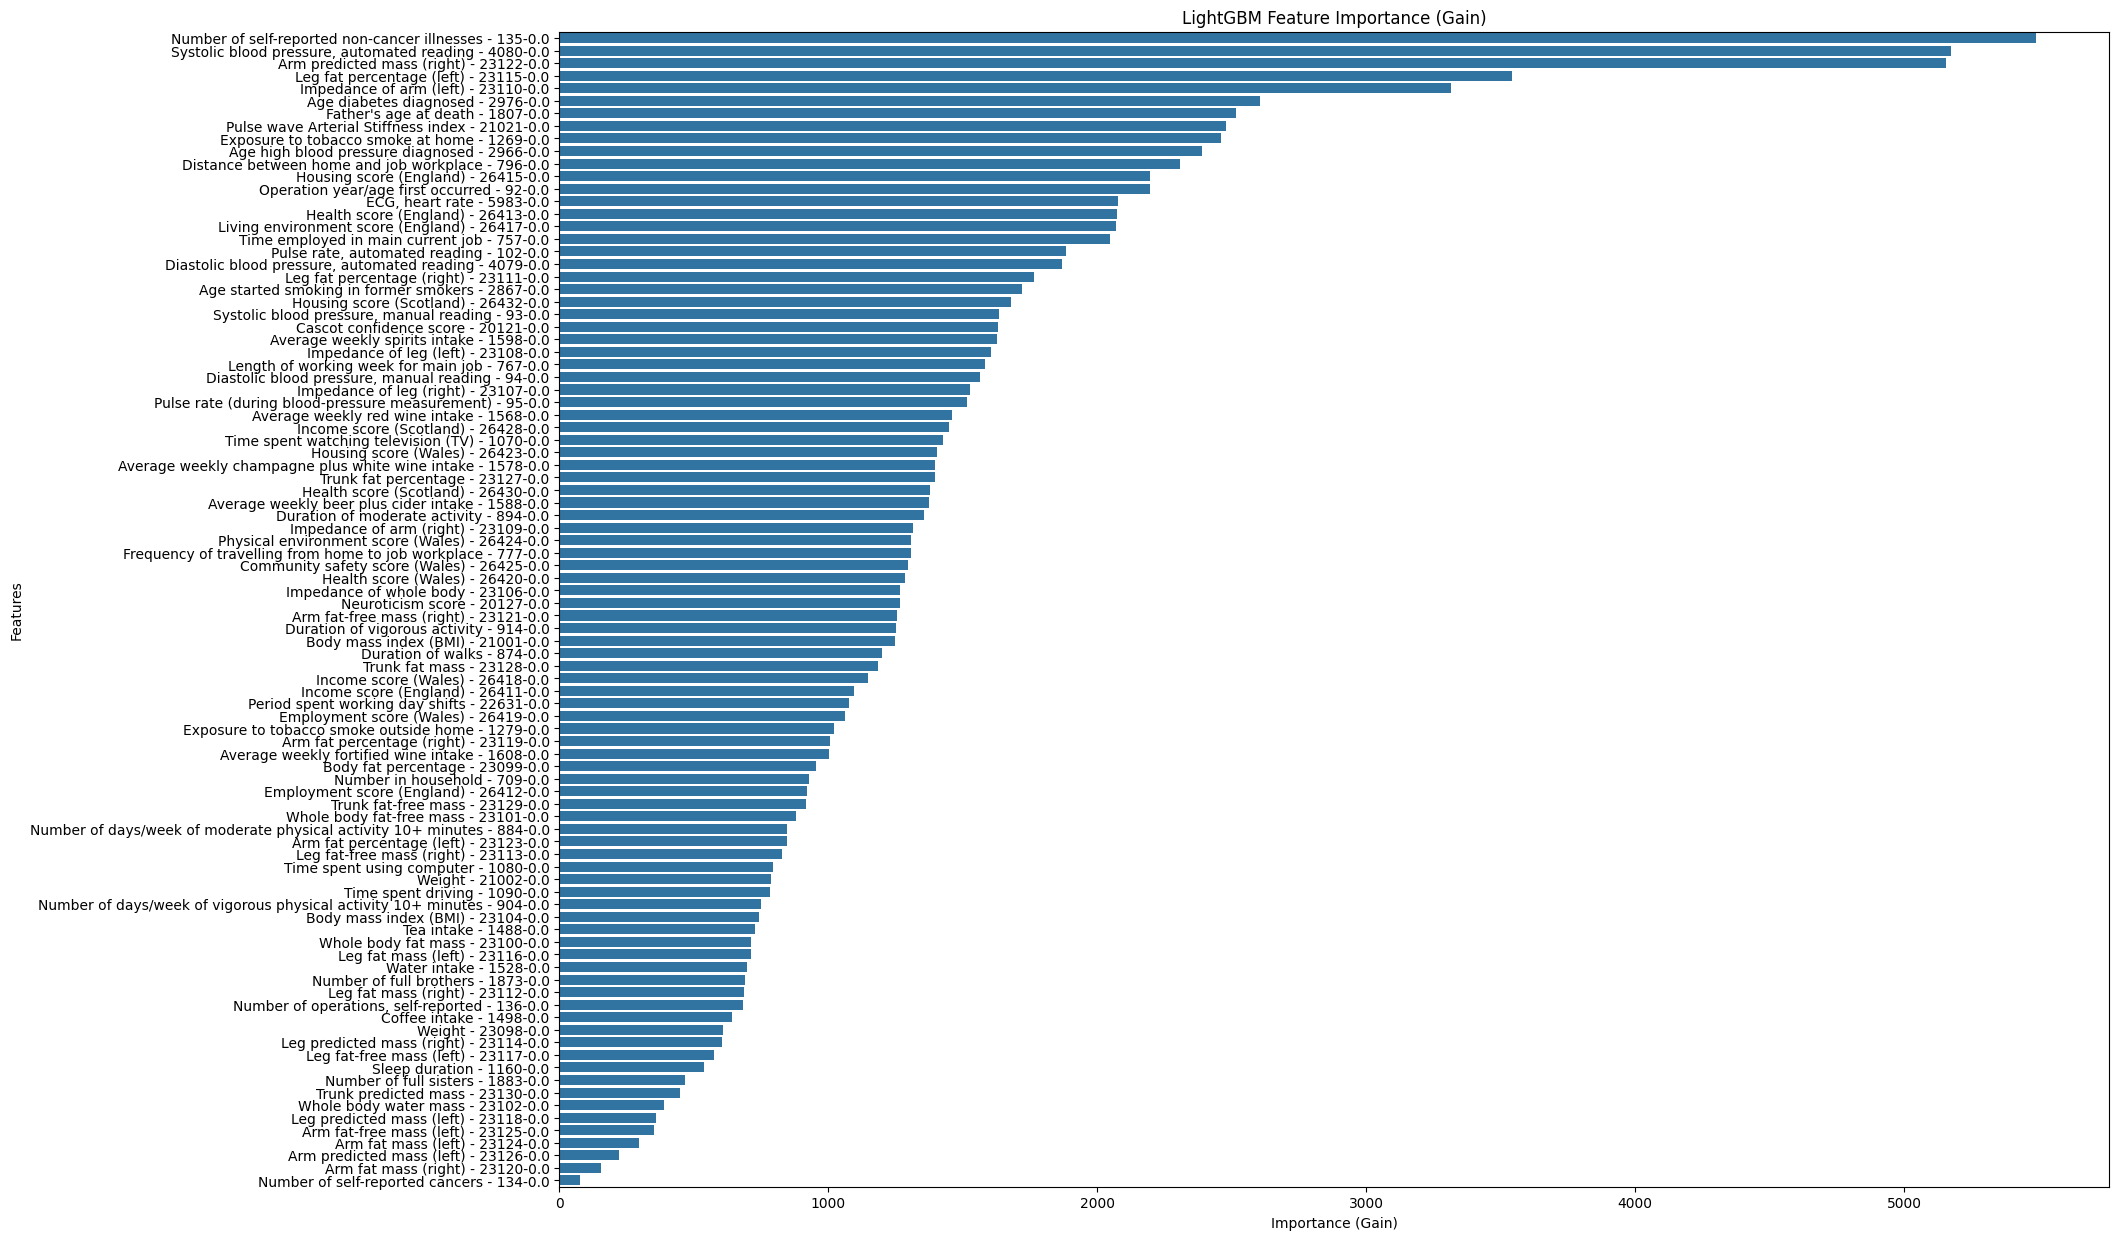

In [16]:
plt.figure(figsize=(20, 15))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'])
plt.title("LightGBM Feature Importance (Gain)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Features")

plt.savefig('lgbm_feature_importance_with_names.png', bbox_inches='tight')
plt.show()

In [24]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [18]:
validation_path = r"../Project/PlayGround/utilfiles/vld_without_onehot.csv"

In [20]:
val_df = pd.read_csv(validation_path)

val_df = val_df[numerical_fields + continuous_fields + ['target']]
val_df = val_df.fillna(val_df.median())

In [29]:
X_validation = val_df.drop(columns=['target', 'eid'])
y_validation = val_df['target'].astype(int)

In [30]:
y_validation.describe()

count    49105.000000
mean         0.028327
std          0.165907
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64

In [37]:
y_prediction = model.predict(X_validation)
y_prediction = [1 if prob >= 0.5 else 0 for prob in y_prediction]

48218

Accuracy Score: 0.9562570003054679
F1 Score: 0.05706760316066725


Classification Report: 
               precision    recall  f1-score   support

       No MI       0.97      0.98      0.98     47714
          MI       0.07      0.05      0.06      1391

    accuracy                           0.96     49105
   macro avg       0.52      0.51      0.52     49105
weighted avg       0.95      0.96      0.95     49105



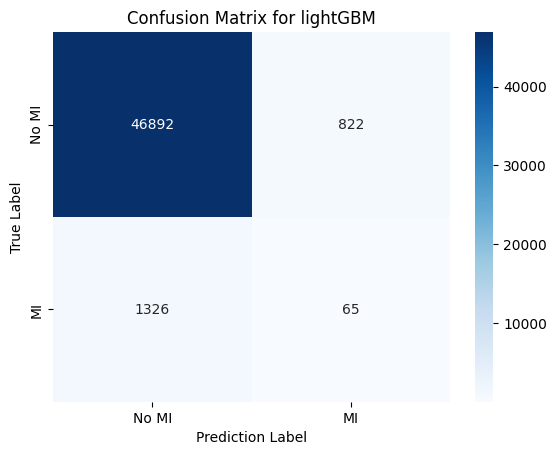

In [39]:

# accuracy_score
accuracy = accuracy_score(y_true=y_validation,y_pred=y_prediction)

f1_score_res = f1_score(y_true=y_validation, y_pred=y_prediction)

# confusion_matrix
cm = confusion_matrix(y_true=y_validation,y_pred=y_prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No MI', 'MI'], yticklabels=['No MI', 'MI'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for lightGBM')

# Classification Report
report = classification_report(y_true=y_validation, y_pred=y_prediction, target_names=['No MI', 'MI'] )

# Show results
print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {f1_score_res}")
print("\n\nClassification Report: \n", report)
plt.show()